ideas for introduction to AB slide or maybe earlier slides:
- talk about prior predictive check
- Beta prior <--> Binomial likelihood
    - we observe some people converted in A and B (likelihood)
    - We want to learn more about conversion probability theta.
    - Hence we need Beta prior for theta
- Exponential prior <--> Gamma likelihood
    - we observe sum of money coming from A and B conversions (likelihood)
    - We want to learn more about average income
    - Hence we need an Exponential prior for mean income



In [19]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

In [20]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

#%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

# Two Variants A, B
## Bernoulli conversion
### PART I: there's no data yet, let's check the prior

In [21]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float



In [23]:
variants  = ['A', 'B']
trials    = [1, 1]
successes = [1, 1]

In [24]:
weak_priors = BetaPrior(alpha=100, beta=100)

In [25]:
with pm.Model() as model:

    theta = pm.Beta("theta", 
                    alpha = weak_priors.alpha, 
                    beta  = weak_priors.beta, 
                    shape = 2)
    
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    reluplift = pm.Deterministic("uplift_B", 
                                 theta[1] / theta[0] - 1)

    weak_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [theta, y]


In [26]:
strong_priors = BetaPrior(alpha=10000, beta=10000)

In [27]:
with pm.Model() as model:

    theta = pm.Beta("theta", 
                    alpha = strong_priors.alpha, 
                    beta  = strong_priors.beta, 
                    shape = 2)
    
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    reluplift = pm.Deterministic("uplift_B", 
                                 theta[1] / theta[0] - 1)

    strong_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [theta, y]


In [28]:
weak_outcome = pd.concat([pd.DataFrame(weak_prior_predictive['theta']), 
                          pd.DataFrame(weak_prior_predictive['y']),
                          pd.DataFrame(weak_prior_predictive['uplift_B'])],
                          axis=1)

weak_outcome.columns = ['theta_A','theta_B','y_A','y_B','uplift_B']
weak_outcome.head(3)

,theta_A,theta_B,y_A,y_B,uplift_B
0,0.495679,0.491388,1,1,-0.008655
1,0.499419,0.512011,0,0,0.025214
2,0.529010,0.491202,1,1,-0.071470


In [29]:
weak_outcome.describe().T

,count,mean,std,min,25%,50%,75%,max
theta_A,10000.0,0.499742,0.035330,0.368088,0.476130,0.499743,0.523643,0.623897
theta_B,10000.0,0.499398,0.035389,0.381978,0.475727,0.499172,0.523163,0.647789
y_A,10000.0,0.500700,0.500025,0.000000,0.000000,1.000000,1.000000,1.000000
y_B,10000.0,0.501600,0.500022,0.000000,0.000000,1.000000,1.000000,1.000000
uplift_B,10000.0,0.004476,0.102346,-0.346444,-0.066277,-0.000141,0.068859,0.498347


In [30]:
strong_outcome = pd.concat([pd.DataFrame(strong_prior_predictive['theta']), 
                             pd.DataFrame(strong_prior_predictive['y']),
                             pd.DataFrame(strong_prior_predictive['uplift_B'])],
                             axis=1)

strong_outcome.columns = ['theta_A','theta_B','y_A','y_B','uplift_B']
strong_outcome.head(3)

,theta_A,theta_B,y_A,y_B,uplift_B
0,0.503160,0.498370,0,1,-0.009519
1,0.493863,0.502653,1,0,0.017799
2,0.496420,0.502091,0,1,0.011425


In [31]:
strong_outcome.describe().T

,count,mean,std,min,25%,50%,75%,max
theta_A,10000.0,0.499981,0.003550,0.486897,0.497561,0.499964,0.502415,0.513919
theta_B,10000.0,0.500013,0.003507,0.487501,0.497619,0.500032,0.502431,0.513888
y_A,10000.0,0.493800,0.499987,0.000000,0.000000,0.000000,1.000000,1.000000
y_B,10000.0,0.512600,0.499866,0.000000,0.000000,1.000000,1.000000,1.000000
uplift_B,10000.0,0.000115,0.010092,-0.034409,-0.006676,0.000111,0.006881,0.038522


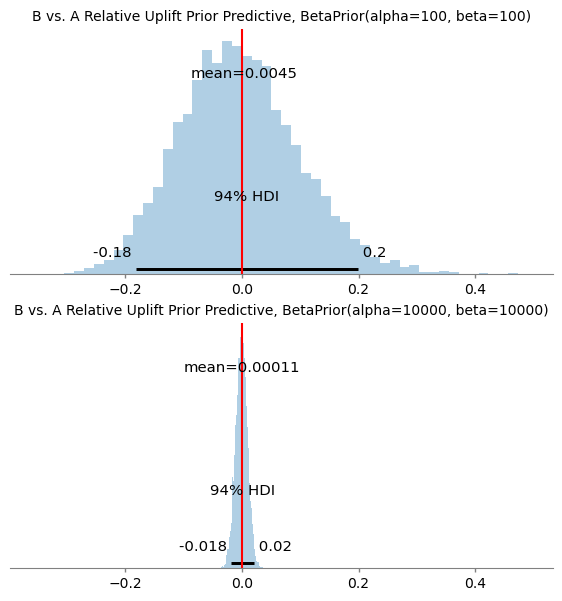

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

az.plot_posterior(weak_outcome["uplift_B"].values, ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs. A Relative Uplift Prior Predictive, {weak_priors}", fontsize=10)
axs[0].axvline(x=0, color="red")

az.plot_posterior(strong_outcome["uplift_B"].values, ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs. A Relative Uplift Prior Predictive, {strong_priors}", fontsize=10)
axs[1].axvline(x=0, color="red");

How we choose these priors in practice depends on broader context of the company running the A/B tests. 

- A strong prior can help guard against false discoveries, but may **require more data** to detect winning variants when they exist (and more data = more time required running the test). 
- A weak prior gives **more weight to the observed data**, but could also lead to more false discoveries as a result of early stopping issues.

### PART II: data is there, let's check the posterior

In [57]:
%run -i temp_tools.py

#### case I: same underlying rates

In [73]:
# case 1: both A and B have the same “true” conversion rates
case1 = pd.DataFrame()
case1['A'] = bernoulli.rvs(p = 0.23, size = 10**5)
case1['B'] = bernoulli.rvs(p = 0.23, size = 10**5)

case1 = case1.aggregate(["count", "sum"]).rename(index={"count": "trials", "sum": "successes"})
case1

,A,B
trials,100000,100000
successes,23025,22812


In [74]:
trials    = [case1['A'].trials, case1['B'].trials]
successes = [case1['A'].successes, case1['B'].successes]

In [58]:
weak_priors = BetaPrior(alpha=100, beta=100)
trace_weak = get_posterior(weak_priors, trials, successes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


In [55]:
strong_priors = BetaPrior(alpha=10000, beta=10000)
trace_strong = get_posterior(strong_priors, trials, successes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


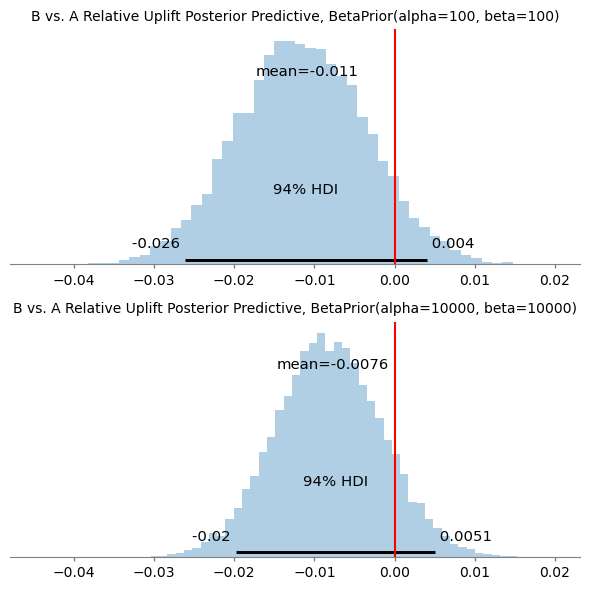

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

az.plot_posterior(trace_weak.posterior["uplift_B"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs. A Relative Uplift Posterior Predictive, {weak_priors}", fontsize=10)
axs[0].axvline(x=0, color="red")

az.plot_posterior(trace_strong.posterior["uplift_B"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs. A Relative Uplift Posterior Predictive, {strong_priors}", fontsize=10)
axs[1].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

- In both cases, the true uplift of 0% lies within the 94% HDI.
- We can then use this relative uplift distribution to make a decision about whether to apply the new landing page / features in Variant B as the default. For example, we can decide that if the 94% HDI is above 0, we would roll out Variant B. In this case, 0 is in the HDI, so the decision would be to not roll out Variant B.

#### case II: different underlying rates

In [67]:
# case II: variant B has a higher true conversion rate
case2 = pd.DataFrame()
case2['A'] = bernoulli.rvs(p = 0.21, size = 10**5)
case2['B'] = bernoulli.rvs(p = 0.23, size = 10**5)

case2 = case2.aggregate(["count", "sum"]).rename(index={"count": "trials", "sum": "successes"})
case2

,A,B
trials,100000,100000
successes,20700,22904


In [75]:
trials    = [case2['A'].trials, case2['B'].trials]
successes = [case2['A'].successes, case2['B'].successes]

In [76]:
weak_priors = BetaPrior(alpha=100, beta=100)
trace_weak = get_posterior(weak_priors, trials, successes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


In [77]:
strong_priors = BetaPrior(alpha=10000, beta=10000)
trace_strong = get_posterior(strong_priors, trials, successes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


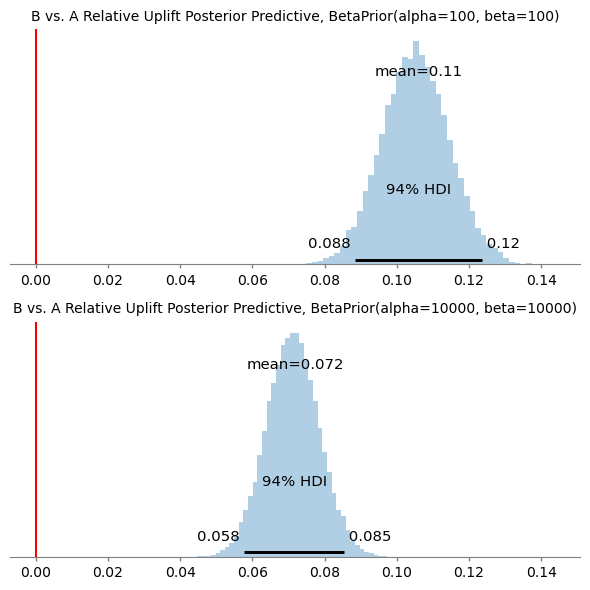

In [78]:
fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True)

az.plot_posterior(trace_weak.posterior["uplift_B"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs. A Relative Uplift Posterior Predictive, {weak_priors}", fontsize=10)
axs[0].axvline(x=0, color="red")

az.plot_posterior(trace_strong.posterior["uplift_B"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs. A Relative Uplift Posterior Predictive, {strong_priors}", fontsize=10)
axs[1].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

- In both cases, the posterior relative uplift distribution suggests that B has a higher conversion rate than A, as the 94% HDI is well above 0. The decision in this case would be to roll out Variant B to all users, and this outcome “true discovery”.

- That said, in practice are usually also interested in how much better Variant B is. For the model with the strong prior, the prior is effectively pulling the relative uplift distribution closer to 0, so our central estimate of the relative uplift is conservative (i.e. understated). We would need much more data for our inference to get closer to the true relative uplift of 9.5%.

The above examples demonstrate how to calculate perform A/B testing analysis for a two-variant test with the simple Beta-Binomial model, and the benefits and disadvantages of choosing a weak vs. strong prior. In the next section we provide a guide for handling a multi-variant (“A/B/n”) test.